In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyAgrum as gum
import pyAgrum.lib.bn2roc as bn2roc
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.image as gimg
import pyAgrum.lib.bn_vs_bn as bn_vs_bn

## Data

In [2]:
data = pd.read_csv("./data/bc.csv")
print(f"Datset shape: {data.shape}")
print(f"Target var distribution: {data["BC"].value_counts()}")
data.head()

Datset shape: (20000, 16)
Target var distribution: BC
No          12439
Invasive     4723
Insitu       2838
Name: count, dtype: int64


,BreastDensity,Location,Age,BC,Mass,AD,Metastasis,MC,Size,Shape,FibrTissueDev,LymphNodes,SkinRetract,NippleDischarge,Spiculation,Margin
0,high,LolwOutQuad,35-49,No,No,No,no,No,<1cm,Other,No,no,No,No,No,Well-defined
1,medium,UpOutQuad,50-74,Invasive,Benign,No,yes,Yes,<1cm,Oval,No,yes,No,Yes,No,Well-defined
2,low,UpInQuad,50-74,Invasive,Benign,No,yes,No,1-3cm,Other,Yes,yes,Yes,No,Yes,Well-defined
3,medium,LowInQuad,>75,Invasive,Malign,No,yes,Yes,<1cm,Round,No,no,No,No,No,Ill-defined
4,high,LowInQuad,<35,No,Benign,No,no,No,>3cm,Oval,No,no,No,No,Yes,Ill-defined


In [3]:
bc = gum.BayesNet()
bc = gum.loadBN("./networks/bc.net")
bc

(pyAgrum.BayesNet<double>@0000017DF98BDBB0) BN{nodes: 16, arcs: 18, domainSize: 10^6.42393, dim: 106, mem: 1Ko 360o}

## Learning Network with Greedy Hill Climb

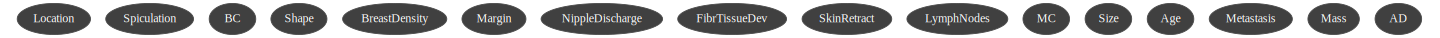

In [4]:
template = gum.BayesNet()

for name in bc.names():
    template.add(bc.variableFromName(name))

gimg.export(template, "./images/tempalte_bc.png")

gnb.showBN(template, size=20)

In [5]:
ghc = gum.BNLearner(data, template)
ghc.useGreedyHillClimbing()
net = ghc.learnBN()
gimg.export(net, "./images/2.2_learned_ghc.png")
net

(pyAgrum.BayesNet<double>@0000017DF98BE750) BN{nodes: 16, arcs: 19, domainSize: 10^6.42393, dim: 90, mem: 1Ko 152o}

## Eval

In [6]:
difference = gum.lib.bn_vs_bn.GraphicalBNComparator(net, bc)
hamming_distance = difference.hamming()
print(hamming_distance)

{'hamming': 1, 'structural hamming': 9}


In [7]:
gnb.flow.add(bn_vs_bn.graphDiff(net, bc),"Difference between learned net vs manually constructed net")
gnb.flow.html()

Purple arrows mean the arrows are reversed

## Learned vs Constructed ROC

./data/bc.csv: 100%|██████████|


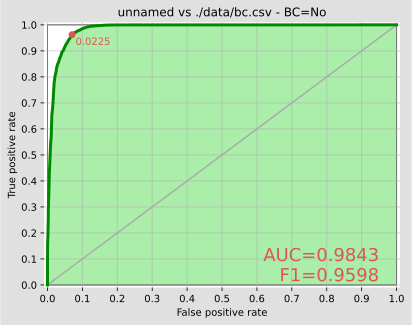

(0.984333062605134, 0.02250498125, 0.9876364272250416, 0.00803564265)

In [8]:
### Learned
bn2roc.showROC(net, "./data/bc.csv",'BC',"No")

./data/bc.csv: 100%|██████████|


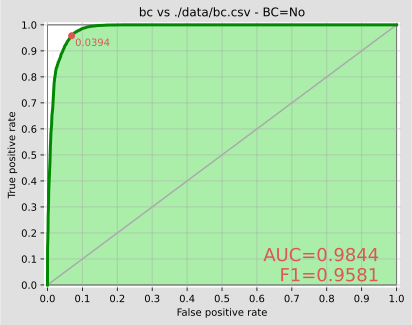

(0.9844364689607249, 0.03940212585, 0.9877535906867647, 0.0138384002)

In [9]:
### Constructed
bn2roc.showROC(bc, "./data/bc.csv",'BC',"No")

## Structural constraints

In [10]:
ghc = gum.BNLearner(data, template)
ghc.useGreedyHillClimbing()
ghc.addMandatoryArc("Age", "BC")
ghc.addMandatoryArc("Location", "BC")
constraint_net = ghc.learnBN()
gimg.export(constraint_net, "./images/2.2_constraint_learned_ghc.png")
net

(pyAgrum.BayesNet<double>@0000017DF98BE750) BN{nodes: 16, arcs: 19, domainSize: 10^6.42393, dim: 90, mem: 1Ko 152o}

In [11]:
difference = gum.lib.bn_vs_bn.GraphicalBNComparator(constraint_net, bc)
hamming_distance = difference.hamming()
print(hamming_distance)

{'hamming': 1, 'structural hamming': 2}


./data/bc.csv: 100%|██████████|


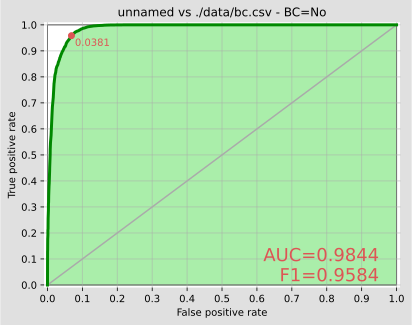

(0.9844462136447925,
 0.038058133300000005,
 0.9877529918673665,
 0.011407502949999999)

In [12]:
bn2roc.showROC(constraint_net, "./data/bc.csv",'BC',"No")

In [13]:
gnb.flow.add(bn_vs_bn.graphDiff(constraint_net, net),"Difference between learned net with constraint vs learned net")
gnb.flow.add(bn_vs_bn.graphDiff(constraint_net, bc),"Difference between learned net with constraint vs manually constructed net") #as we can see only error left is that location points into BC instead BC into Location
gnb.flow.html()